In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set(style='ticks', context='paper', font='CMU Sans Serif')

In [16]:
def find_record(records, matrix, oversub):
    for record in records:
        has_matrix = matrix in record['spatial']
        has_oversub = oversub in record['cluster']
        if has_matrix and has_oversub:
            return record['id']
    print('failed to find record')
    return None
    
def read_normalized_loads(id):
    with open(f'../data/{id}/pmn-m/loads.json') as f:
        loads = np.array(json.load(f))
        loads.sort()
        loads = loads[::-1]
        loads = loads / loads[0]
    return pd.DataFrame(loads, columns=['load'])

In [17]:
with open('../spec/all.mix.json') as f:
    records = json.load(f)

a_1 = find_record(records, 'cluster_a', '1_to_1')
a_4 = find_record(records, 'cluster_a', '4_to_1')
b_1 = find_record(records, 'cluster_b', '1_to_1')
b_4 = find_record(records, 'cluster_b', '4_to_1')
c_1 = find_record(records, 'cluster_c', '1_to_1')
c_4 = find_record(records, 'cluster_c', '4_to_1')

In [18]:
df_a_1 = read_normalized_loads(a_1)
df_b_1 = read_normalized_loads(b_1)
df_c_1 = read_normalized_loads(c_1)
df_a_1.loc[:, 'kind'] = 'Matrix A'
df_b_1.loc[:, 'kind'] = 'Matrix B'
df_c_1.loc[:, 'kind'] = 'Matrix C'
df_1 = pd.concat([df_a_1, df_b_1, df_c_1], ignore_index=True)
df_1['pct'] = df_1.groupby(by=['kind'], as_index=False)['load'].rank(pct=True)
df_1.loc[:, 'oversub'] = '1-to-1'

In [19]:
df_a_4 = read_normalized_loads(a_4)
df_b_4 = read_normalized_loads(b_4)
df_c_4 = read_normalized_loads(c_4)
df_a_4.loc[:, 'kind'] = 'Matrix A'
df_b_4.loc[:, 'kind'] = 'Matrix B'
df_c_4.loc[:, 'kind'] = 'Matrix C'
df_4 = pd.concat([df_a_4, df_b_4, df_c_4], ignore_index=True)
df_4['pct'] = df_4.groupby(by=['kind'], as_index=False)['load'].rank(pct=True)
df_4.loc[:, 'oversub'] = '4-to-1'

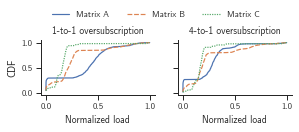

In [27]:
df = pd.concat([df_1, df_4])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 1), sharey=True)
for i, oversub in enumerate(['1-to-1', '4-to-1']):
    ax = sns.lineplot(x='load', y='pct', hue='kind', style='kind', data=df[df['oversub'] == oversub], ax=axs[i], ci=None)
    ax.set_title(f'{oversub} oversubscription')
    ax.set_xlabel('Normalized load')
    ax.set_ylabel('CDF')
    handles = ax.get_legend().get_lines()
    ax.get_legend().remove()
# XXX: This is a dirty hack. Comment the above line to check handles and labels match up before doing anything.
fig.legend(handles=handles, labels=['Matrix A', 'Matrix B', 'Matrix C'], loc='upper center', frameon=False, ncol=3, bbox_to_anchor=(0.48, 1.4))
sns.despine()
plt.savefig('figs/link-loads.pdf', bbox_inches='tight')